In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc

import seaborn as sns

In [2]:
with open("../merged_results.json", "r") as f:
    scores = json.load(f)

In [4]:
def sum_ensemble(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    m = min(len(a), len(b))
    return a[:m] + b[:m]

def min_ensemble(a, b):
    return np.minimum(a, b)

def max_ensemble(a, b):
    return np.maximum(a, b)

def avg_ensemble(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return (a + b) / 2

def havg(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return 2 / ((1 / a) + (1 / b))

ensemble_funcs = [sum_ensemble, min_ensemble, max_ensemble, avg_ensemble, havg]
# eg_keys = ['ue1', 'ue2', 'sum_ensemble', 'min_ensemble', 'max_ensemble', 'avg_ensemble', 'havg']
eg_keys = ['ue1', 'ue2']

In [5]:
def get_xlabel(reg):
    mapping = {
        'ue1': 'SumEigV',
        'ue2': 'ECC',
        'sum_ensemble': 'SumEigV + ECC',
        'max_ensemble': 'Max(SumEigV, ECC)',
        'min_ensemble': 'Min(SumEigV, ECC)',
        'avg_ensemble': 'Average of UEs',
        'havg': 'Harmonic Average of UEs'
    }
    return mapping.get(reg, reg)

def get_xs(reg, d):
    ue1 = d["ue1"]
    ue2 = d["ue2"]
    mapping = {
        "ue1": ue1,
        "ue2": ue2,
        "sum_ensemble": sum_ensemble(ue1, ue2),
        "min_ensemble": min_ensemble(ue1, ue2),
        "max_ensemble": max_ensemble(ue1, ue2),
        "avg_ensemble": avg_ensemble(ue1, ue2),
        "havg": havg(ue1, ue2)
    }
    return mapping[reg]



In [18]:
def compute_roc_analysis(final_answers, ensemble_funcs=None):
    all_ue1, all_ue2, all_safe_scores = [], [], []
    results = {}

    for key, scores in final_answers.items():
        if "ue1" not in scores or "ue2" not in scores or "safe_scores" not in scores:
            continue
        all_ue1.extend(scores["ue1"])
        all_ue2.extend(scores["ue2"])
        all_safe_scores.extend(scores["safe_scores"])

    ue1 = np.array(all_ue1)
    ue2 = np.array(all_ue2)
    safe_labels = np.array(all_safe_scores)
    safe_labels = 1 - safe_labels  # 0=correct, 1=incorrect

    # ue1
    fpr1, tpr1, thresholds1 = roc_curve(safe_labels, ue1)
    auc1 = roc_auc_score(safe_labels, ue1)
    results["ue1"] = {"roc_auc": float(auc1), "fpr": fpr1.tolist(), "tpr": tpr1.tolist(), "thresholds": thresholds1.tolist()}

    # ue2
    fpr2, tpr2, thresholds2 = roc_curve(safe_labels, ue2)
    auc2 = roc_auc_score(safe_labels, ue2)
    results["ue2"] = {"roc_auc": float(auc2), "fpr": fpr2.tolist(), "tpr": tpr2.tolist(), "thresholds": thresholds2.tolist()}

    # ensembles
    if ensemble_funcs:
        for f in ensemble_funcs:
            ue_ensemble = f(ue1, ue2)
            fpr_e, tpr_e, thresholds_e = roc_curve(safe_labels, ue_ensemble)
            auc_e = roc_auc_score(safe_labels, ue_ensemble)
            key_name = getattr(f, "__name__", str(f))
            results[key_name] = {"roc_auc": float(auc_e),
                                 "fpr": fpr_e.tolist(),
                                 "tpr": tpr_e.tolist(),
                                 "thresholds": thresholds_e.tolist()}
    return results


res = compute_roc_analysis(final_answers=scores, ensemble_funcs=ensemble_funcs)


/tmp/ipykernel_175473/4155487692.py:21: RuntimeWarning: divide by zero encountered in divide
  return 2 / ((1 / a) + (1 / b))


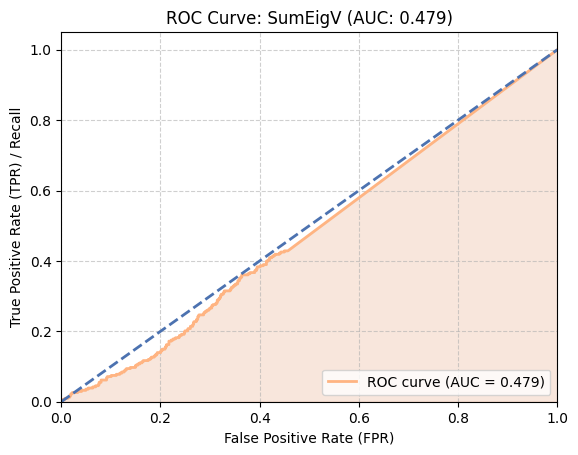

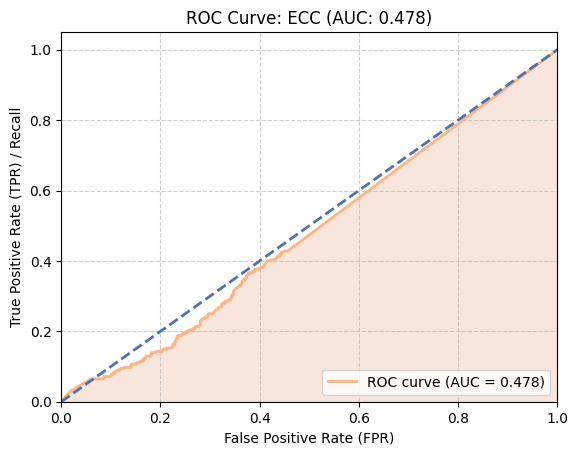

ROC plots generated.


In [22]:
palette1 = sns.color_palette("pastel")
palette = sns.color_palette("deep")
c_random_line = '--'
c_random = palette[0]
c_line = palette1[1]
c_shade = palette[1]

for reg in eg_keys:
    data = res[reg]
    fpr = data["fpr"]
    tpr = data["tpr"]
    auc_val = data["roc_auc"]

    plt.figure()
    plt.plot(fpr, tpr, color=c_line, lw=2, label=f'ROC curve (AUC = {auc_val:.3f})')
    plt.fill_between(fpr, tpr, alpha=0.2, color=c_shade)
    plt.plot([0, 1], [0, 1], color=c_random, linestyle=c_random_line, lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR) / Recall")
    plt.title(f"ROC Curve: {get_xlabel(reg)} (AUC: {auc_val:.3f})")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f"{reg}_roc_curve.png", dpi=400, bbox_inches="tight")
    plt.show()

print("ROC plots generated.")


In [20]:
def compute_regression(final_answers, ensemble_funcs=None):
    agg_ue1, agg_ue2, agg_safe = [], [], []
    results = {}

    for key, scores in final_answers.items():
        if "ue1" not in scores or "ue2" not in scores or "safe_scores" not in scores:
            continue

        ue1_avg = np.mean(scores["ue1"])
        ue2_avg = np.mean(scores["ue2"])
        
        safe_prop = np.sum(scores["safe_scores"]) / len(scores["safe_scores"])

        agg_ue1.append(ue1_avg)
        agg_ue2.append(ue2_avg)
        agg_safe.append(safe_prop)

    ue1 = np.array(agg_ue1)
    ue2 = np.array(agg_ue2)
    safe = np.array(agg_safe).reshape(-1, 1)

    def process_metric(name, ue_values):
        model = LinearRegression().fit(safe, ue_values)
        r2 = model.score(safe, ue_values)
        y_pred = model.predict(safe)
        
        results[name] = {
            "slope": float(model.coef_[0]),
            "intercept": model.intercept_,
            "score": r2,
            "safe": safe,    
            "y_pred": y_pred,        
            "ue": ue_values      
        }

    process_metric("ue1", ue1)
    process_metric("ue2", ue2)

    if ensemble_funcs:
        for f in ensemble_funcs:
            ue_ensemble = f(ue1, ue2)
            key_name = getattr(f, "__name__", str(f))
            process_metric(key_name, ue_ensemble)

    return results

In [12]:
res_reg = compute_regression(final_answers=scores, ensemble_funcs=ensemble_funcs)

In [13]:
for reg in eg_keys:
    data = res_reg[reg]
    
    x_axis = data['safe'] 
    y_raw = data['ue']     
    slope = data["slope"]
    intercept = data["intercept"]
    r2_val = data["score"]

    plt.figure(figsize=(8, 6))

    plt.scatter(x_axis, y_raw, alpha=0.5, color=c_shade, label='Actual Data')

    x_range = np.linspace(x_axis.min(), x_axis.max(), 100) 
    y_range = x_range * slope + intercept
    
    plt.plot(x_range, y_range, color=c_random, linestyle='--', lw=2, 
             label=f"Best Fit: y = {slope:.3f}x + {intercept:.3f}")

    plt.xlabel("Safe Score (Accuracy)")
    plt.ylabel("Uncertainty Estimate (UE)")
    plt.title(f"Regression: {reg} (R² = {r2_val:.3f})")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.savefig(f"{reg}_regression_plot.png", dpi=300, bbox_inches="tight")
    plt.show()

print("Regression plots generated.")

KeyError: 'sum'

In [ ]:
def compute_prr_analysis(final_answers, ensemble_funcs=None):
    all_ue1, all_ue2, all_safe_scores = [], [], []
    results = {}

    for key, scores in final_answers.items():
        if "ue1" not in scores or "ue2" not in scores or "safe_scores" not in scores:
            continue
        all_ue1.extend(scores["ue1"])
        all_ue2.extend(scores["ue2"])
        all_safe_scores.extend(scores["safe_scores"])

    ue1 = np.array(all_ue1)
    ue2 = np.array(all_ue2)
    safe_labels = 1 - np.array(all_safe_scores)

    def calculate_arc(uncertainties, errors):
        n_samples = len(errors)
        if n_samples == 0: return 0.0, [], []
        
        sorted_indices = np.argsort(uncertainties)[::-1]
        sorted_errors = errors[sorted_indices]
        
        total_errors = np.sum(sorted_errors)
        errors_found_cumsum = np.cumsum(sorted_errors)
        
        rejection_indices = np.arange(n_samples)
        n_remaining = n_samples - rejection_indices
        
        n_remaining[n_remaining == 0] = 1 
        
        errors_remaining = total_errors - np.concatenate(([0], errors_found_cumsum[:-1]))
        accuracies = (n_remaining - errors_remaining) / n_remaining
        rejection_rates = rejection_indices / n_samples
        
        area = auc(rejection_rates, accuracies)
        return area

    auc_random = 1.0 - np.mean(safe_labels)

    auc_oracle = calculate_arc(safe_labels, safe_labels)

    methods = [("ue1", ue1), ("ue2", ue2)]
    
    if ensemble_funcs:
        for f in ensemble_funcs:
            key_name = getattr(f, "__name__", str(f))
            methods.append((key_name, f(ue1, ue2)))

    for name, scores in methods:
        auc_score = calculate_arc(scores, safe_labels)
        
        # PRR 
        if (auc_oracle - auc_random) > 0:
            prr_score = (auc_score - auc_random) / (auc_oracle - auc_random)
        else:
            prr_score = 0.0 
            
        results[name] = {
            "prr": float(prr_score),  

        }

    return results

In [16]:
res_prr = compute_prr_analysis(final_answers=scores, ensemble_funcs=ensemble_funcs)
print(res_prr)

{'ue1': {'prr': -0.06812457671522566}, 'ue2': {'prr': -0.01890950447788526}, 'sum_ensemble': {'prr': -0.05488843783875115}, 'min_ensemble': {'prr': -0.06812457671522566}, 'max_ensemble': {'prr': -0.01890950447788526}, 'avg_ensemble': {'prr': -0.05488843783875115}, 'havg': {'prr': -0.02753978119837163}}


/tmp/ipykernel_181361/178924306.py:21: RuntimeWarning: divide by zero encountered in divide
  return 2 / ((1 / a) + (1 / b))


In [ ]:

def results_to_df(results):
    clean_data = []
    
    for method_name, metrics in results.items():
        scalar_metrics = {
            k: v for k, v in metrics.items() 
            if not isinstance(v, (list, np.ndarray))
        }
        scalar_metrics['Method'] = method_name
        clean_data.append(scalar_metrics)
    
    df = pd.DataFrame(clean_data)
    
    if not df.empty:
        df.set_index('Method', inplace=True)
        
        # Sort by prr
        df = df.sort_values(by='prr', ascending=False)
            
    return df

df_results = results_to_df(res_prr)

print(df_results)

                   prr
Method                
ue2          -0.018910
max_ensemble -0.018910
havg         -0.027540
avg_ensemble -0.054888
sum_ensemble -0.054888
ue1          -0.068125
min_ensemble -0.068125
